<a href="https://colab.research.google.com/github/kasozivincent/Generative_Adversarial_Networks/blob/main/generation_of_small_color_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Reshape
from keras.layers import BatchNormalization, Flatten, LeakyReLU, Dropout
from keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from matplotlib import pyplot as plt

## Data generator for the model

In [ ]:
class ModelData():
    def __init__(self, latent_dim, number_of_samples):
        self.latent_dim = latent_dim
        self.number_of_samples = number_of_samples
    
    # this function generates latent points that are fed to the generator
    def generate_latent_points(self):
        return np.random.randn(self.number_of_samples, self.latent_dim)
    
    #function to generate real data
    def create_real_data(self):
        (x_train, _) , (_ , _) = cifar10.load_data()
        x = np.expand_dims(x_train, -1) #mnist images are (28, 28) but the model expects (28, 28, 1)
        x = x.astype('float32')
        x = (x - 127.5) / 127.5
        return x
    
    #function to generate real labeled data randomly
    def generate_real_data(self):
        dataset = self.create_real_data()
        idx = np.random.randint(0, len(dataset), self.number_of_samples)
        Xs = dataset[idx]
        Ys = np.ones((self.number_of_samples, 1))
        return Xs, Ys

    #function to generate discriminator inputs during training
    def generator_outputs(self, generator):
        x_input = self.generate_latent_points()
        X = generator.predict(x_input)
        y = np.zeros((self.number_of_samples, 1))
        return X, y

## class defining the generator model

In [ ]:
class Generator():
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
    def __call__(self):
      return self.generator()

    def generator(self):
        # foundation for 7x7 image
        input_layer = Input(shape=self.latent_dim)

        #generate enough units that can be reshaped to a 7x7x128 output
        x = Dense(units=256*4*4)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        x = Reshape((4, 4, 256))(x)

        # upsample to 8x8x128
        x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

        # upsample to 16x16x128
        x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

        # upsample to 32x32x128
        x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

        output_layer = Conv2D(3, kernel_size=4, activation='tanh', padding='same')(x)
        model = Model(inputs=[input_layer], outputs=[output_layer], name='generator')
        return model

In [ ]:
G = Generator(100)
G().summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        13

## class defining the discriminator model

In [ ]:
class Discriminator():
    def __init__(self, inputs=(32, 32, 3)):
        self.inputs = inputs
    
    def __call__(self):
      return self.discriminator()
      
    def discriminator(self):
        input_layer = Input(shape=self.inputs)
        x = Conv2D(64, kernel_size=3, padding='same')(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
       
        x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)

        x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
        
        x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.4)(x)
        
        x = Flatten()(x)
        output_layer = Dense(units=1, activation='sigmoid')(x)
        # compile model
        model = Model(inputs=[input_layer], outputs=[output_layer])
        opt = Adam(learning_rate=0.0002, beta_1=0.5)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

## Gan Model. It is a composite of the generator and 

In [ ]:
class GanModel():
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        
    def ganModel(self):
        self.discriminator.trainable = False
        model = Sequential()
        model.add(self.generator)
        model.add(self.discriminator)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
        return model

## model analyser during training

In [ ]:
class Analyser():
    def __init__(self, generator, discriminator):
        self.discriminator = discriminator
        self.generator = generator
        self.modelData = ModelData(100, 16)
        
    def plot(self):
        images = self.generator.predict(self.modelData.generate_latent_points())
        images = (images + 1) / 2.0
        for i in range(16):
            plt.subplot(4, 4, 1 + i)
            plt.axis('off')
            plt.imshow(images[i])
        plt.show()
      
    def plot_history(self, real_loss, fake_loss, gan_loss):
        plt.subplot(1, 1, 1)
        plt.plot(real_loss, label='d-real')
        plt.plot(fake_loss, label='d-fake')
        plt.plot(gan_loss, label='gen')
        plt.legend()
        plt.ylim([0,1])
        plt.show()


## Model Trainer

In [ ]:
class Trainer():
    def __init__(self, epochs, batch, e_val, discriminator, generator, gan_model):
        self.discriminator = discriminator
        self.generator = generator
        self.gan_model = gan_model
        self.epochs = epochs
        self.batch = batch
        self.modelData = ModelData(100, batch)
        self.analyser = Analyser(self.generator, self.discriminator)
        self.e_val = e_val
    
    def train(self):
        real_loss = []
        fake_loss = []
        gan_loss = []
        for epoch in range(self.epochs):
            #Generate real data
            x_real, y_real = self.modelData.generate_real_data()
            #Generate fake data
            x_fake, y_fake = self.modelData.generator_outputs(self.generator)
            #Train discriminator
            dloss1, _ = self.discriminator.train_on_batch(x_real, y_real)
            dloss2, _ = self.discriminator.train_on_batch(x_fake,y_fake)
            #Generate latent points
            g_data = self.modelData.generate_latent_points()
            g_labels = np.ones((self.batch, 1))
            
            #Train Gan model
            gloss, _ = self.gan_model.train_on_batch(g_data, g_labels)
            real_loss.append(dloss1)
            fake_loss.append(dloss2)
            gan_loss.append(gloss)

            if (epoch + 1) % self.e_val == 0:
                print(f'epoch : {epoch + 1} real loss : {dloss1} fake loss : {dloss2} gan loss : {gloss}')
                self.analyser.plot()
        self.analyser.plot_history(real_loss, fake_loss, gan_loss)

## Composition root

In [ ]:
dis = Discriminator().discriminator()
gen = Generator(100).generator()
gan = GanModel(gen, dis).ganModel()


170500096/170498071 [==============================] - 3s 0us/step
epoch : 1000 real loss : 0.2639109492301941 fake loss : 0.26918697357177734 gan loss : 2.052838087081909


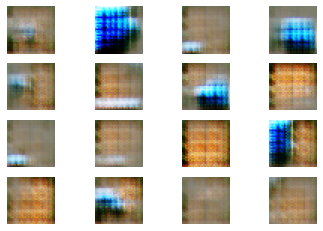

epoch : 2000 real loss : 0.5139692425727844 fake loss : 0.5081151723861694 gan loss : 1.309569001197815


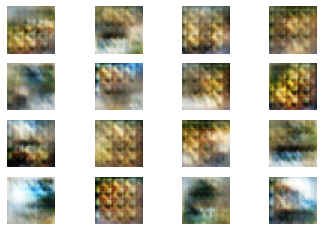

epoch : 3000 real loss : 0.6395264863967896 fake loss : 0.6415978074073792 gan loss : 1.7319787740707397


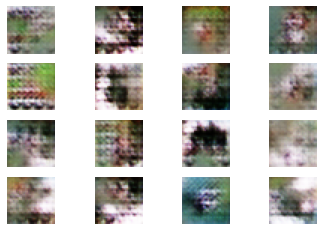

epoch : 4000 real loss : 0.42233750224113464 fake loss : 0.4307188391685486 gan loss : 1.4051692485809326


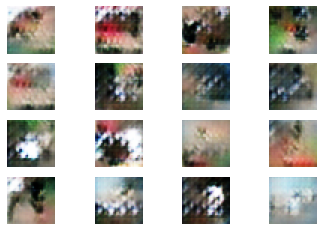

epoch : 5000 real loss : 0.5954042673110962 fake loss : 0.4604873061180115 gan loss : 1.6529477834701538


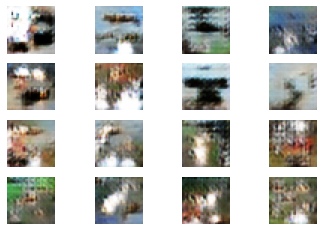

epoch : 6000 real loss : 0.5935841798782349 fake loss : 0.6674650311470032 gan loss : 1.1860966682434082


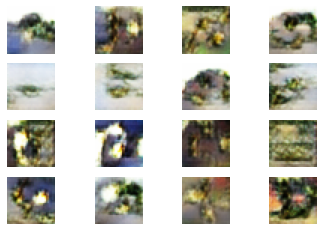

epoch : 7000 real loss : 0.6197817325592041 fake loss : 0.5181386470794678 gan loss : 1.2525744438171387


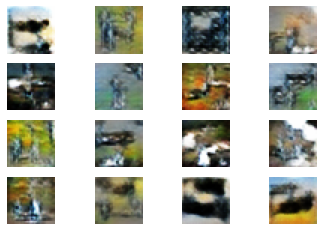

epoch : 8000 real loss : 0.6913211345672607 fake loss : 0.4548974633216858 gan loss : 1.1644070148468018


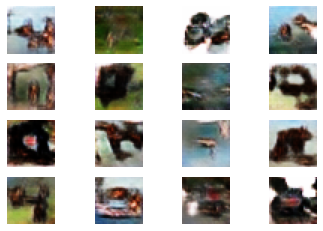

epoch : 9000 real loss : 0.5558426380157471 fake loss : 0.5778776407241821 gan loss : 0.9146010875701904


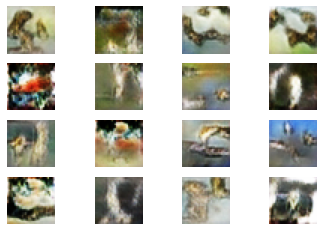

epoch : 10000 real loss : 0.637913703918457 fake loss : 0.5235767960548401 gan loss : 0.8787654638290405


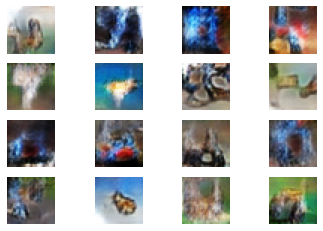

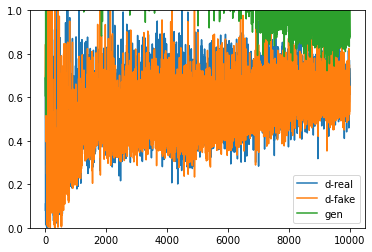

In [ ]:
trainer = Trainer(10000, 32, 1000, dis, gen, gan)
trainer.train()